<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Basic Image Manipulation in Python</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM 480A5, Spring 2025
Instructor: Brian Munsky
Authors: Will Raymond, Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



# Abstract

This notebook provides a list of procedures to analyze images with the goal of trying to classify those images.

## Learning Objectives

Upon completion of this notebook, you should be able to:

1. Create a group of classified images to use as training data.
2. Apply simple image manipulations to curate that data and make it is easier to process.
3. Build a few different classifiers to exrtract information from the data.

We are going to demonstrate these tools using hand-written data sets that we create ourselves.

# **1. Create Worksheet to collect data.**
In this notebook, we are going to perform a supervised learning process to learn how to classify handwritten digits. But, before we can do any classification, we are going to need a bunch of training data. For this, we need to design an experiment where we know the answers.  In this case, I created a handout of boxes for you to write numbers.  Here is how I created that handout.

In [1]:
# Load 144 random images with replacement from the set 'box0.jpg', 'box1.jpg', ..., 'box9.jpg'.
# Then, display the images in a 12x12 grid, and save the grid as 'montage.png'.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import skimage

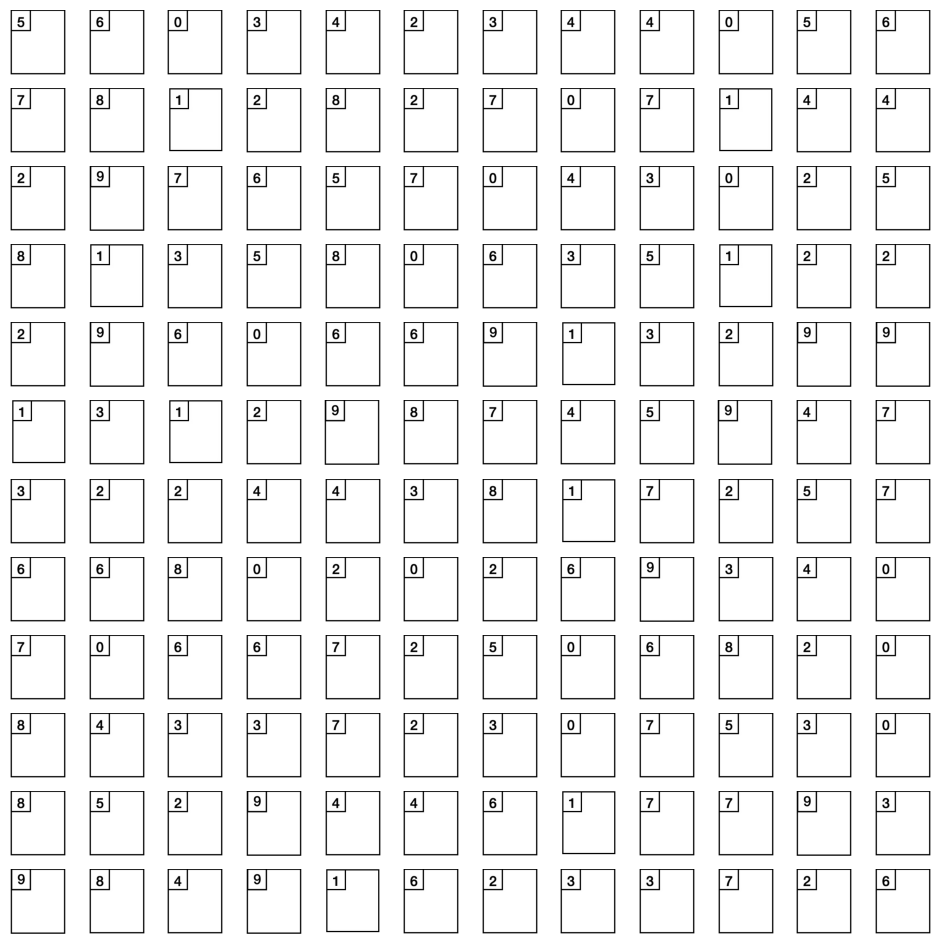

In [2]:
# Set the random seed for reproducibility.
np.random.seed(1)

# Load 144 random images with replacement from the set 'box0.jpg', 'box1.jpg', ..., 'box9.jpg' in the folder
# 'handDigits' and store them in a list.
images = []
labelPage = []
for i in range(144):
    ri = random.randint(0, 9)
    # Append the image to the list.
    images.append(mpimg.imread('handDigits/box' + str(ri) + '.jpg'))
    # Append the label to the list.
    labelPage.append(ri)

# Create a 12x12 grid of subplots.
fig, axs = plt.subplots(12, 12, figsize=(12, 12))

# Display the images in the grid.
for i in range(12):
    for j in range(12):
        axs[i, j].imshow(images[i * 12 + j])
        axs[i, j].axis('off')

# Save the grid
plt.savefig('handDigits/handDigitSheet.png')
plt.show()

In [3]:
# Unfortunately, when I created the original sheet I did not set the RNG seed,
# so the labels are not reproducible.  Instead, I am going to have to write them out by hand :(.
labelPage = [6, 6, 0, 4, 8, 7, 6, 4, 7, 5, 9, 3,
             8, 2, 4, 2, 1, 9, 4, 8, 9, 2, 4, 1,
             1, 5, 7, 8, 1, 5, 6, 5, 9, 3, 8, 7,
             7, 8, 4, 0, 8, 0, 1, 6, 0, 9, 7, 5,
             3, 5, 1, 3, 9, 3, 3, 2, 8, 7, 1, 1,
             5, 8, 7, 1, 4, 8, 4, 1, 8, 5, 8, 3,
             9, 8, 9, 4, 7, 1, 9, 6, 5, 9, 3, 4,
             2, 3, 2, 0, 9, 4, 7, 1, 1, 2, 2, 0,
             1, 8, 6, 8, 4, 8, 3, 3, 9, 6, 9, 4,
             7, 7, 5, 1, 5, 9, 1, 7, 9, 5, 3, 3,
             0, 4, 1, 3, 5, 2, 5, 6, 0, 1, 2, 3,
             0, 9, 8, 9, 1, 0, 1, 3, 9, 9, 1, 6]

# **Collect and Process the Collected Data.**

## **Loading the data into python.**

In [4]:
# Load image 'handDigits/scannedSheet.pdf,' with a single page,
# then convert it to a 2D NumPy array with high resolution
# and then display the image.
# !pip install PyMuPDF
import fitz
doc = fitz.open('handDigits/scannedSheetMultiPagePortrait.pdf')
nPages = doc.page_count
imgSet = []
for iPage in range(nPages):
    print(f'Opening page {iPage}')
    page = doc.load_page(iPage)
    pix = page.get_pixmap(matrix=fitz.Matrix(3, 3))
    img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
    # rotate the image 90 degrees to the left
    # img = np.rot90(img,3)
    imgSet.append(img)

Opening page 0
Opening page 1
Opening page 2
Opening page 3
Opening page 4
Opening page 5
Opening page 6
Opening page 7
Opening page 8
Opening page 9
Opening page 10
Opening page 11
Opening page 12
Opening page 13
Opening page 14
Opening page 15
Opening page 16


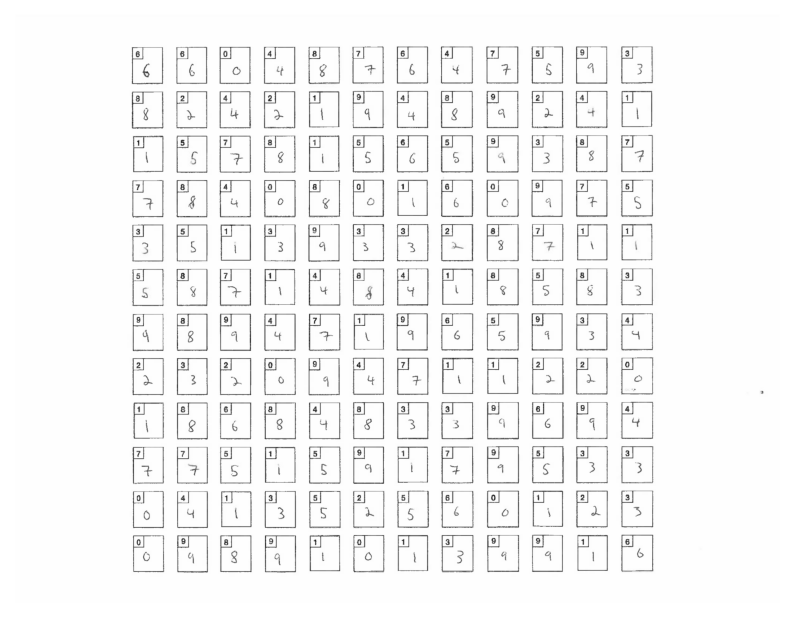

In [5]:
# Show one of the images.
plt.figure(figsize=(10, 10))
plt.imshow(imgSet[0])
plt.axis('off')
plt.show()

## Assigning labels to the known data.

In this example, I know that the first several pages all have the numbers in the same order.  So, I am going to use that order to assign labels to the collected images.

## Segmenting images into individual training data points.

One of the most difficult steps in working with real images, is that there can be many interesting features on a single image, and we want to separate these out.  We will learn more about segmentation in the next lesson, but for now we just want to separate out the boxes with the different numbers so we can later build a model.

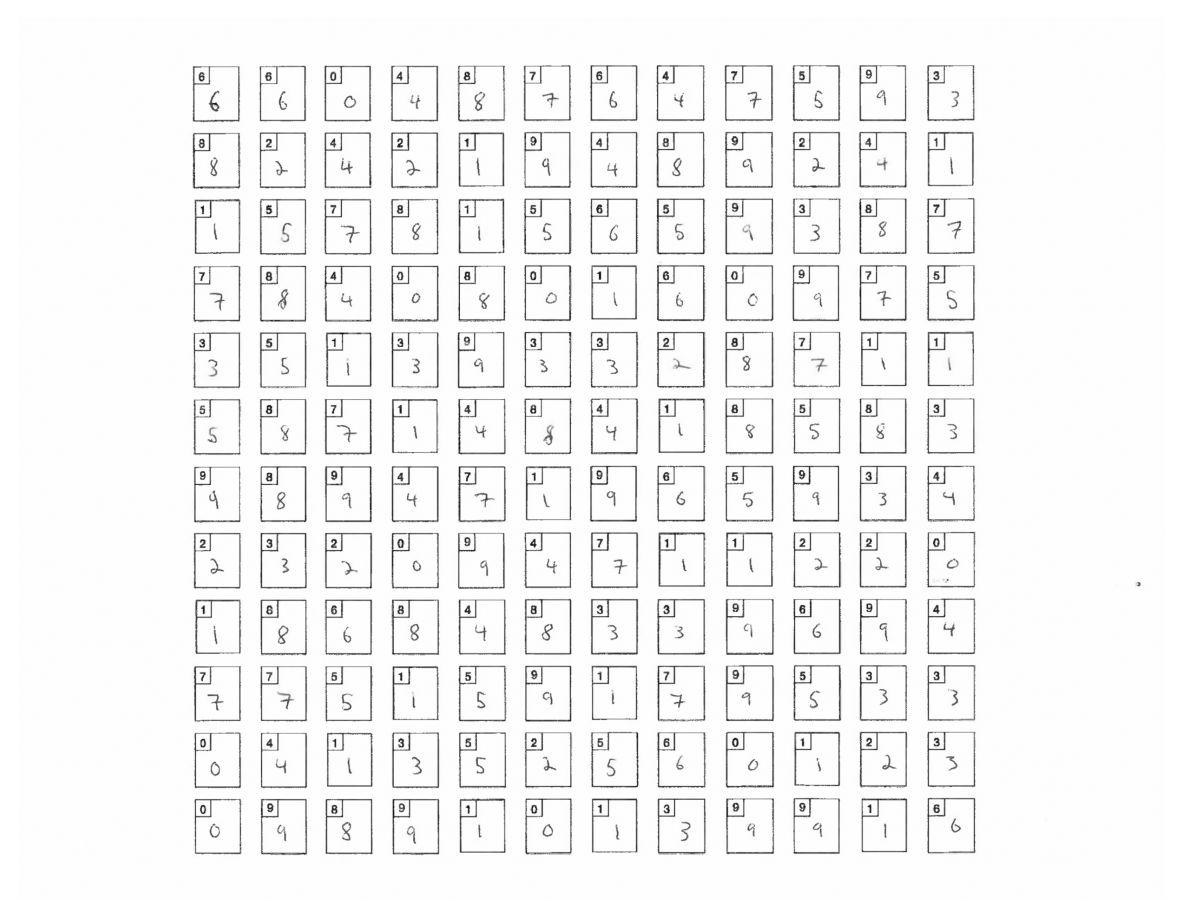

In [6]:
# Convert the image to a grayscale image and display it.
gray_img = np.mean(imgSet[0], axis=2)
plt.figure(figsize=(15, 15))
plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.show()

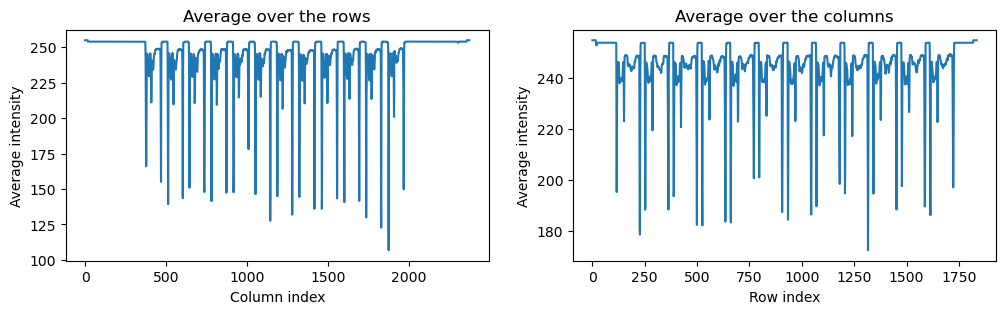

In [7]:
# Average the grayscale image over the rows and display the resulting 1D NumPy array.
gray_img = np.mean(imgSet[0], axis=2)
average_Row = np.mean(gray_img, axis=0)
average_Column = np.mean(gray_img, axis=1)

# Create two subplots, one for the average over the rows and one for the average over the columns.
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].plot(average_Row)
axs[0].set_title('Average over the rows')
axs[0].set_xlabel('Column index')
axs[0].set_ylabel('Average intensity')
axs[1].plot(average_Column)
axs[1].set_title('Average over the columns')
axs[1].set_xlabel('Row index')
axs[1].set_ylabel('Average intensity')
plt.show()

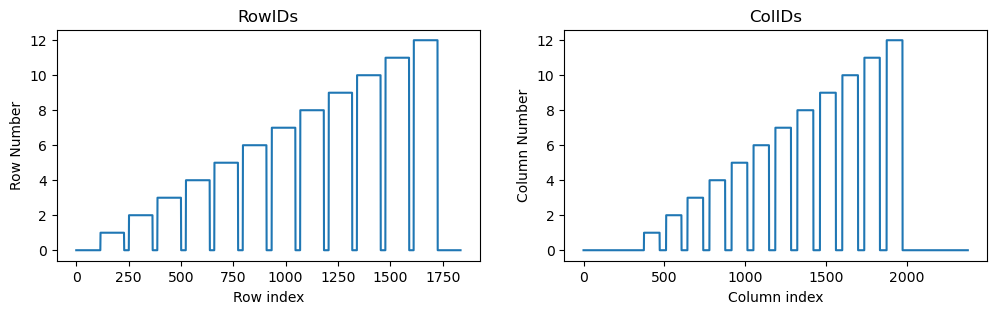

In [8]:
colIDs = np.zeros_like(average_Row)
rowNumber = 0
for i in range(1, len(average_Row)-1):
    if average_Row[i] > 250:
        colIDs[i] = 0
    elif average_Row[i-1] > 250:
        rowNumber += 1
        colIDs[i] = 0
    elif average_Row[i+1] > 250:
        colIDs[i] = 0
    else:
        colIDs[i] = rowNumber

rowIDs = np.zeros_like(average_Column)
colNumber = 0
for i in range(1, len(average_Column)-1):
    if average_Column[i] > 250:
        rowIDs[i] = 0
    elif average_Column[i-1] > 250:
        colNumber += 1
        rowIDs[i] = 0
    elif average_Column[i+1] > 250:
        rowIDs[i] = 0    
    else:
        rowIDs[i] = colNumber

# Create two subplots, one for the RowIDs and one for the ColIDs.
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].plot(rowIDs)
axs[0].set_title('RowIDs')
axs[0].set_xlabel('Row index')
axs[0].set_ylabel('Row Number')
axs[1].plot(colIDs)
axs[1].set_title('ColIDs')
axs[1].set_xlabel('Column index')
axs[1].set_ylabel('Column Number')
plt.show()

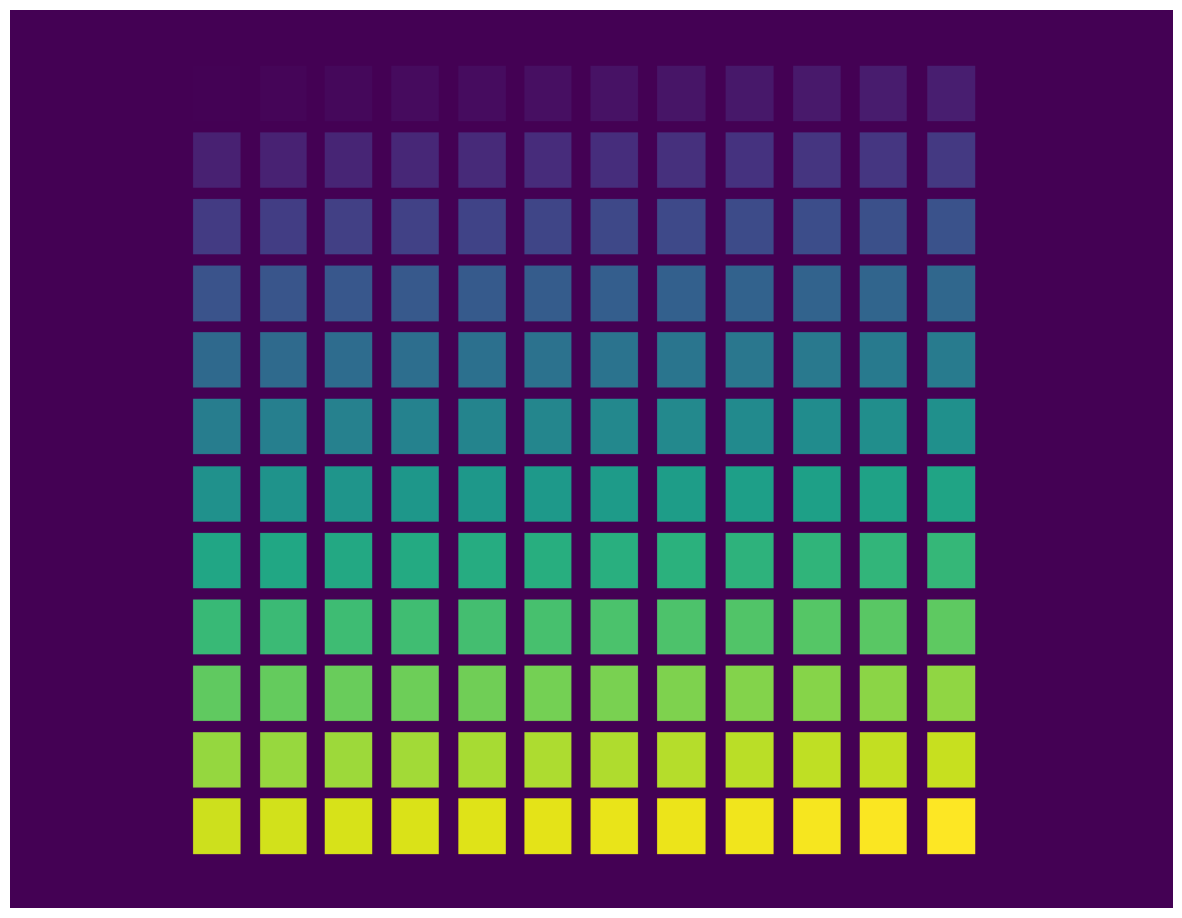

In [9]:
# Create a numpy array of the same size as the grayscale image, but where the value of each entry is 
# 12*rowID + colID, where rowID and colID are the row and column IDs of the corresponding entry in the
# grayscale image.
mask = np.zeros_like(gray_img).astype(int)
for i in range(1, len(average_Column)):
    for j in range(1, len(average_Row)):
        if rowIDs[i]>0 and colIDs[j]>0:
            mask[i][j] = 12*(rowIDs[i]-1) + colIDs[j] 

# Display the mask.
plt.figure(figsize=(15, 15))
plt.imshow(mask)
plt.axis('off')
plt.show()

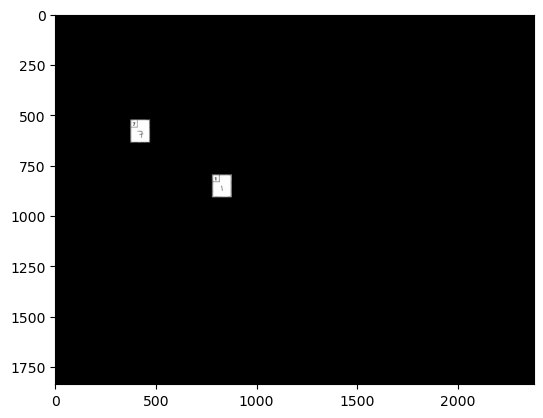

In [10]:
plt.imshow(gray_img*((mask==37)+(mask==64)), cmap='gray')

Average size of subimages: [112  96]


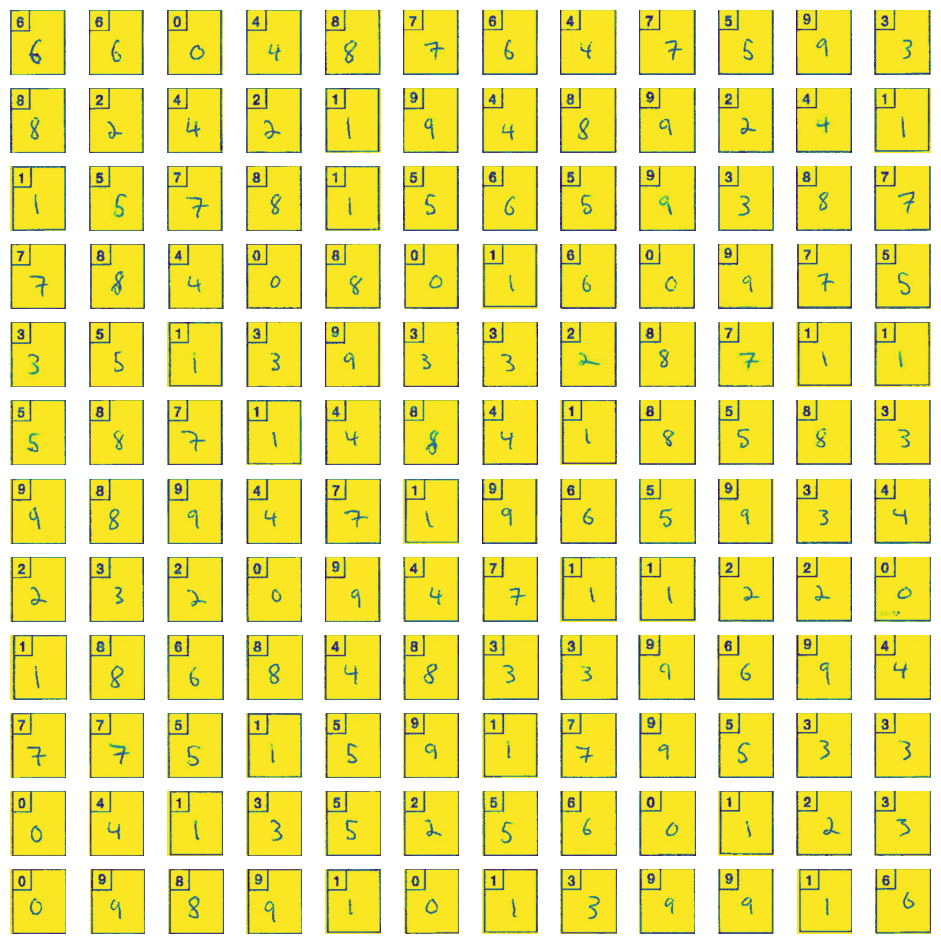

In [11]:
# Loop through the mask and create a subimage from the grayscale image for each unique value in the mask.
# Then, display the subimages in a 12x12 grid.
subImages = []
row = []
col = []

for i in range(1,np.max(mask)+1):
    row.append(np.any(mask==i, axis=1))
    col.append(np.any(mask==i, axis=0))

for i in range(1,np.max(mask)+1):
    if np.sum(mask==i)>6000:
        rmin, rmax = np.where(row[i-1])[0][[0, -1]]
        cmin, cmax = np.where(col[i-1])[0][[0, -1]]
        subImages.append(gray_img[rmin:rmax, cmin:cmax])

# Find the average size of the subimages
avgSize = np.mean([[img.shape[0], img.shape[1]] for img in subImages], axis=0).astype(int)
print(f'Average size of subimages: {avgSize}')

fig, axs = plt.subplots(12, 12, figsize=(12, 12))
for i in range(12):
    for j in range(12):
        axs[i, j].imshow(subImages[i * 12 + j])
        axs[i, j].axis('off')
plt.show()

In [12]:
# Create a function to redo the above steps for a given page of the PDF.
def process_page(img, expectedImagesPerPage=144):
    # Convert the image to a grayscale image and display it.
    gray_img = np.mean(img, axis=2)

    # Crop off the margins of the image.
    gray_img = gray_img[50:gray_img.shape[0]-50, 300:gray_img.shape[1]-275]

    # Average the grayscale image over the rows and display the resulting 1D NumPy array.
    average_Row = np.mean(gray_img, axis=0)
    average_Column = np.mean(gray_img, axis=1)

    colIDs = np.zeros_like(average_Row)
    rowNumber = 0
    for i in range(1, len(average_Row)-1):
        if average_Row[i] > 250:  # If in a white area
            colIDs[i] = 0
        elif average_Row[i-1] > 250: # If in a black area to the right to a white area
            rowNumber += 1
            colIDs[i] = 0
        elif average_Row[i+1] > 250: # If in a black area to the left to a white area
            colIDs[i] = 0
        else:
            colIDs[i] = rowNumber

    rowIDs = np.zeros_like(average_Column)
    colNumber = 0
    for i in range(1, len(average_Column)-1):
        if average_Column[i] > 250:
            rowIDs[i] = 0
        elif average_Column[i-1] > 250:
            colNumber += 1
            rowIDs[i] = 0
        elif average_Column[i+1] > 250:
            rowIDs[i] = 0    
        else:
            rowIDs[i] = colNumber

    mask = np.zeros_like(gray_img).astype(int)
    for i in range(1, len(average_Column)):
        for j in range(1, len(average_Row)):
            if rowIDs[i]>0 and colIDs[j]>0:
                mask[i][j] = 12*(rowIDs[i]-1) + colIDs[j]   

    # Display the mask.
    plt.figure(figsize=(6, 6))
    plt.imshow(mask)
    plt.axis('off')
    plt.show() 

    subIms = []
    for i in range(1,np.max(mask)+1):
        # Apply threshold on image size to remove stubs.
        if np.sum(mask==i)>6000:
            row = np.any(mask==i, axis=1)
            col = np.any(mask==i, axis=0)

            rmin, rmax = np.where(row)[0][[0, -1]]
            cmin, cmax = np.where(col)[0][[0, -1]]

            pad = 4
            subImage = gray_img[rmin-pad:rmax+pad, cmin-pad:cmax+pad]

            # Resize the image to match the average size from above. This might require interpolation.
            subImage = skimage.transform.resize(subImage, (avgSize[0], avgSize[1]), anti_aliasing=True)
            
            subIms.append(subImage)

    # Check if the number of subimages is less or more than expected.
    if len(subIms) != expectedImagesPerPage:
        print(f'Warning: Expected {expectedImagesPerPage} images, but found {len(subIms)} images.')
        print('skipping page')
        return []
    else:
        return subIms     

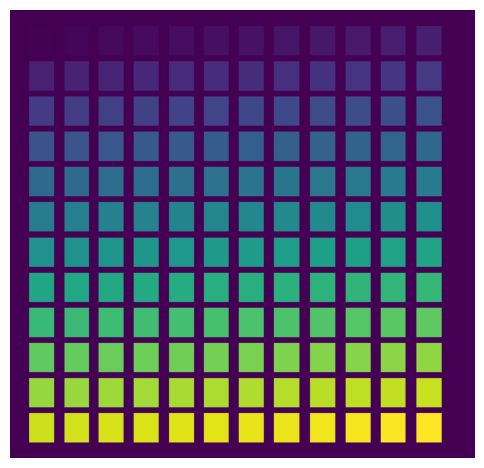

Processed page 0


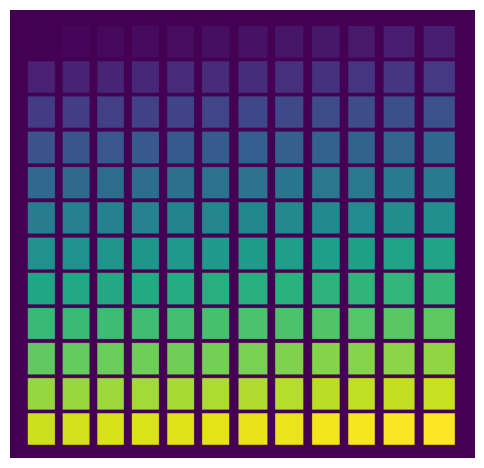

Processed page 1


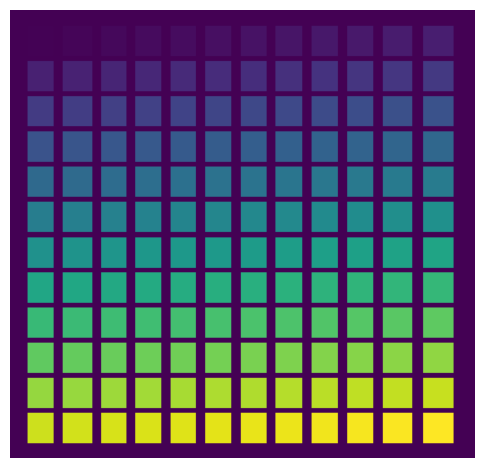

Processed page 2


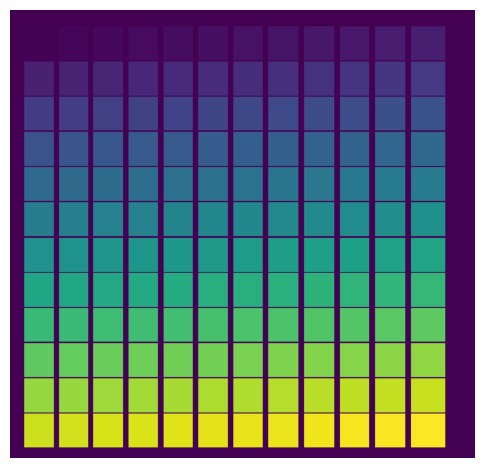

Processed page 3


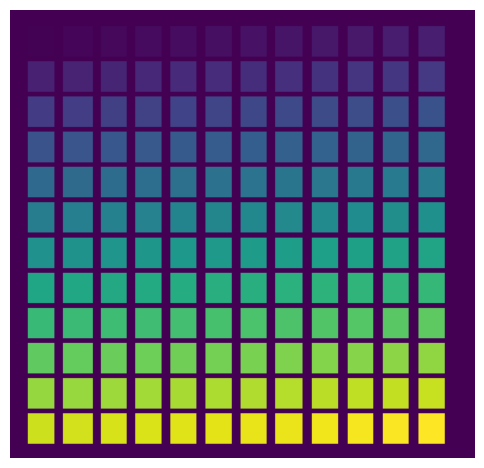

Processed page 4


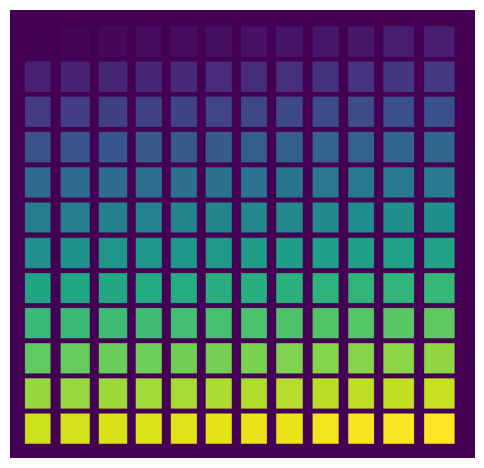

Processed page 5


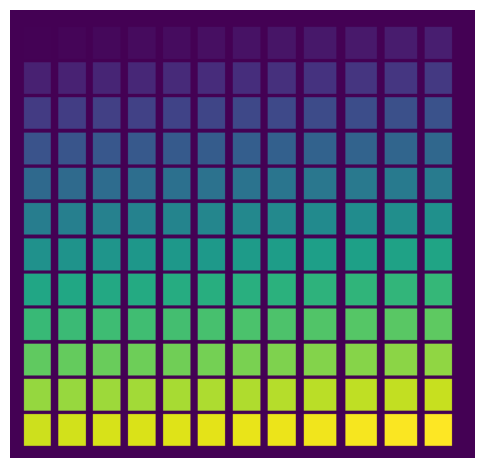

Processed page 6


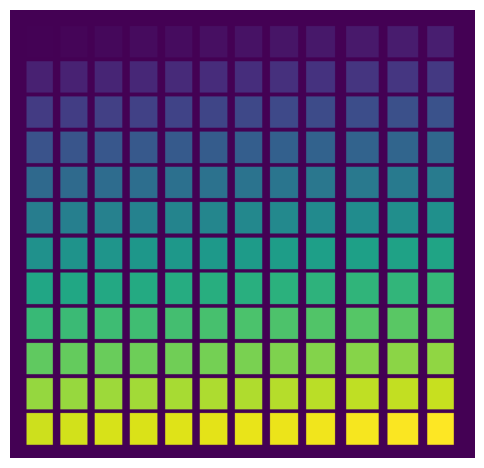

Processed page 7
total number of subimages for training and validation: 1152


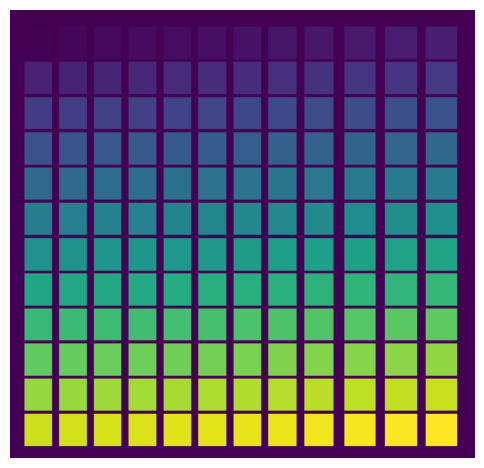

Processed page 8


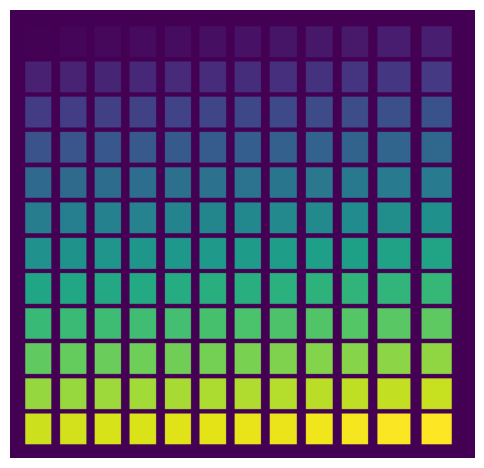

Processed page 9


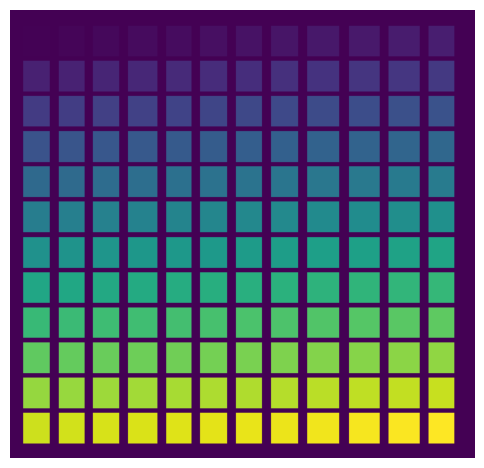

Processed page 10


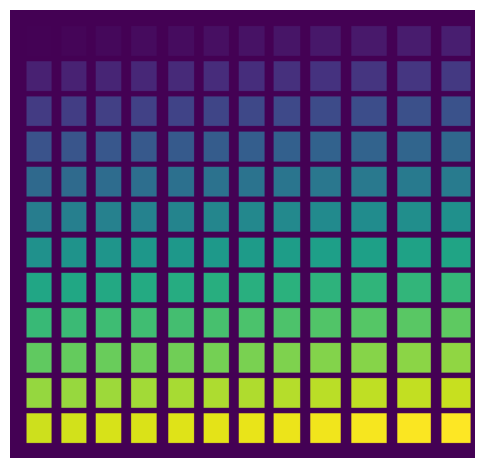

Processed page 11


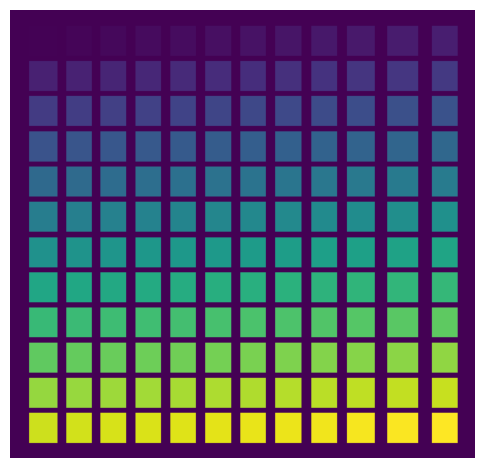

Processed page 12


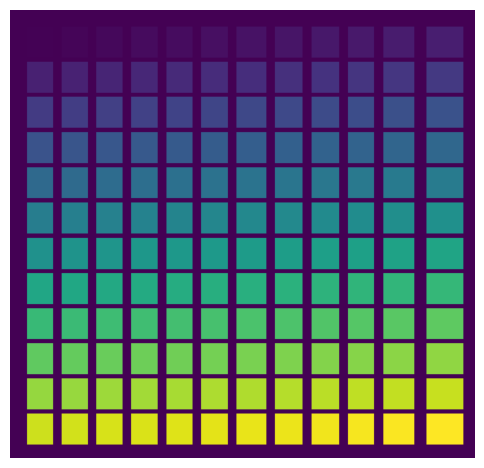

Processed page 13


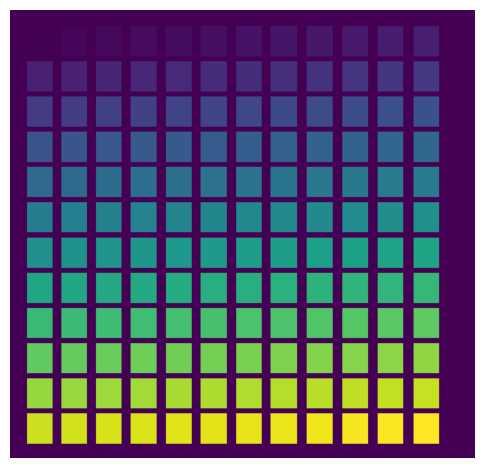

Processed page 14


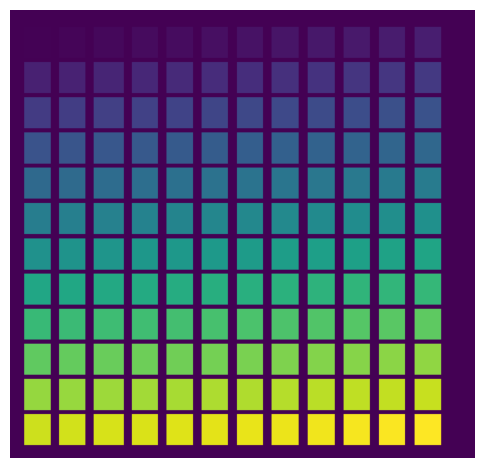

Processed page 15


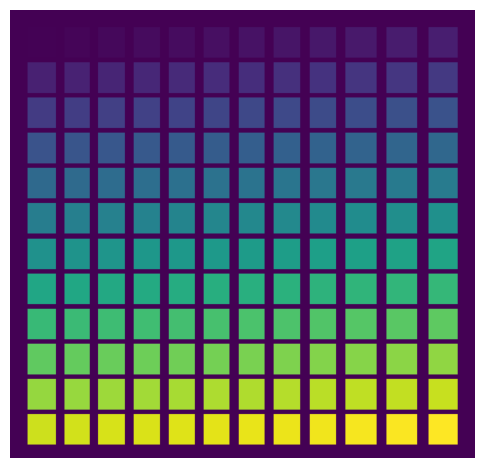

Processed page 16
total number of subimages for testing: 1296


In [13]:
# Process first 8 pages of the PDF for training and validation data.
subImages = []
i =0
labels = []
for page in imgSet[:8]:
    try:
        subImages.extend(process_page(page))
        print(f'Processed page {i}')
        labels = labels + labelPage
    except:
        print(f'Error processing image {i}')
    i+=1 

print(f'total number of subimages for training and validation: {len(subImages)}')

# Process the remaining pages as unlabeled testing data.
subImagesTest = []
for page in imgSet[8:]:
    try:
        subImagesTest.extend(process_page(page))
        print(f'Processed page {i}')
        labels = labels + labelPage
    except:
        print(f'Error processing image {i}')
    i+=1 

print(f'total number of subimages for testing: {len(subImagesTest)}')

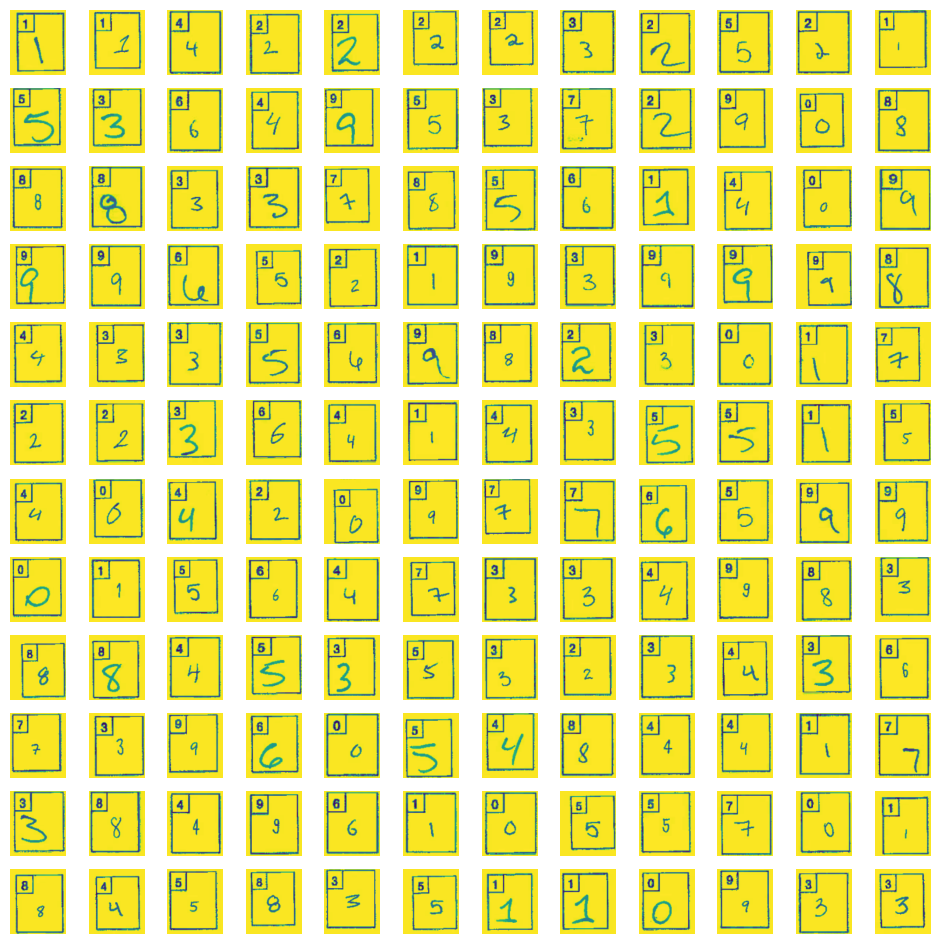

In [14]:
# Show a random 12x12 sample of the training subimages.
randIndices = random.sample(range(len(subImages)), 144)
fig, axs = plt.subplots(12, 12, figsize=(12, 12))
for i in range(12):
    for j in range(12):
        axs[i, j].imshow(subImages[randIndices[i * 12 + j]])
        axs[i, j].axis('off')
plt.show()


## Curating Data to Remove Artificial Cues

In [15]:
# Unfortunately, many of the images are a bit off center, so we need to crop and pad them to make them all the same size.

# Create a function that loops over all iamges and crops to remove white space at the top.
# it then pads the bottom of the image to make it the same size as the original image.
def crop_pad(imgs):

    imgsOut = []
    # Crop the top of each image until the average intensity of the first line is less than firstLineMean.
    for i, img in enumerate(imgs):
        # Find average intensity along rows and columns
        intensityRow = np.mean(img, axis=0)
        intensityCol = np.mean(img, axis=1)
        # Find first row that is not white
        cmin = np.where(intensityRow < 200)[0][0]
        # Find last row that is not white
        cmax = np.where(intensityRow < 200)[0][-1]
        # Find first column that is not white
        rmin = np.where(intensityCol < 200)[0][0]
        # Find last column that is not white
        rmax = np.where(intensityCol < 200)[0][-1]

        imgCopy = img.copy()
        
        # Crop the image
        imgCopy = imgCopy[rmin:rmax, cmin:cmax]
        # Resize the image to the average size
        imgCopy = skimage.transform.resize(imgCopy, (avgSize[0], avgSize[1]), anti_aliasing=True)
        
        imgsOut.append(imgCopy)

    return imgsOut

# Crop and pad the training and validation subimages.
subImagesAdjust = crop_pad(subImages)
subImagesTestAdjust = crop_pad(subImagesTest)

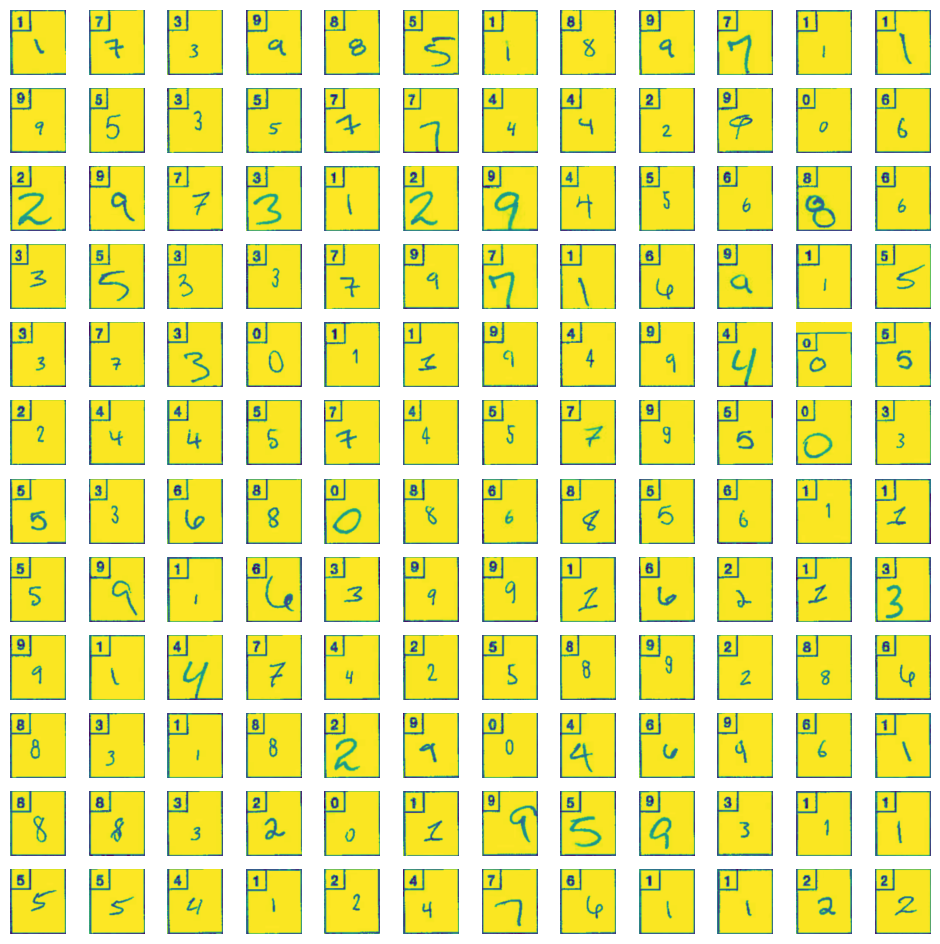

In [16]:
# Show a random 12x12 sample of the training subimages.
randIndices = random.sample(range(len(subImages)), 144)

fig, axs = plt.subplots(12, 12, figsize=(12, 12))
for i in range(12):
    for j in range(12):
        axs[i, j].imshow(subImagesAdjust[randIndices[i * 12 + j]])
        axs[i, j].axis('off')
plt.show()  

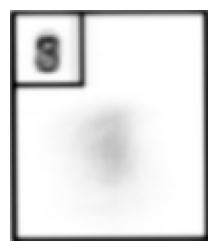

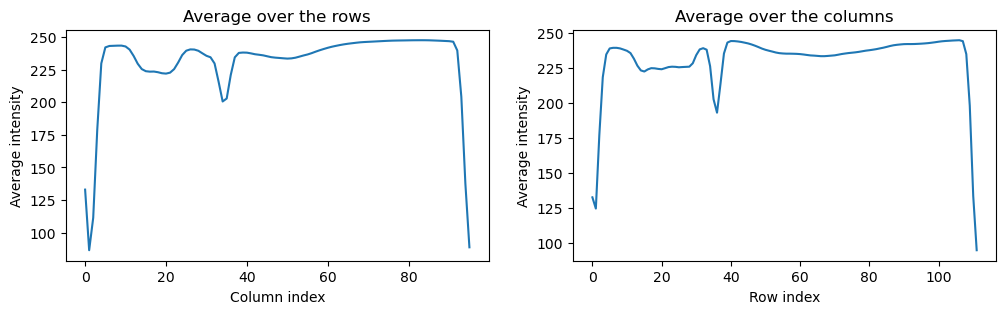

In [17]:
# Loop over the subimages and find the minimum width and height of the subimages.
minWidth = subImagesAdjust[0].shape[1]
minHeight = subImagesAdjust[0].shape[0]
for i in range(len(subImagesAdjust)):
    if subImagesAdjust[i].shape[1] < minWidth:
        minWidth = subImagesAdjust[i].shape[1]
    if subImagesAdjust[i].shape[0] < minHeight:
        minHeight = subImagesAdjust[i].shape[0]
        
# Create an average image by averaging the subimages. Truncate each subimage to the minimum width and height
# before averaging.
averageImage = np.zeros((minHeight, minWidth))
for i in range(len(subImagesAdjust)):
    averageImage += subImagesAdjust[i][:minHeight, :minWidth]
averageImage /= len(subImagesAdjust)

# Display the average image.
plt.figure(figsize=(3, 3))
plt.imshow(averageImage, cmap='gray')
plt.axis('off')
plt.show()

# Compute the row and column averages of the average image and display the resulting 1D NumPy arrays.
average_Row = np.mean(averageImage, axis=0)
average_Column = np.mean(averageImage, axis=1)

# Create two subplots, one for the average over the rows and one for the average over the columns.
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].plot(average_Row)
axs[0].set_title('Average over the rows')
axs[0].set_xlabel('Column index')
axs[0].set_ylabel('Average intensity')
axs[1].plot(average_Column)
axs[1].set_title('Average over the columns')
axs[1].set_xlabel('Row index')
axs[1].set_ylabel('Average intensity')
plt.show()


## Creating Training Data and Assigning Labels

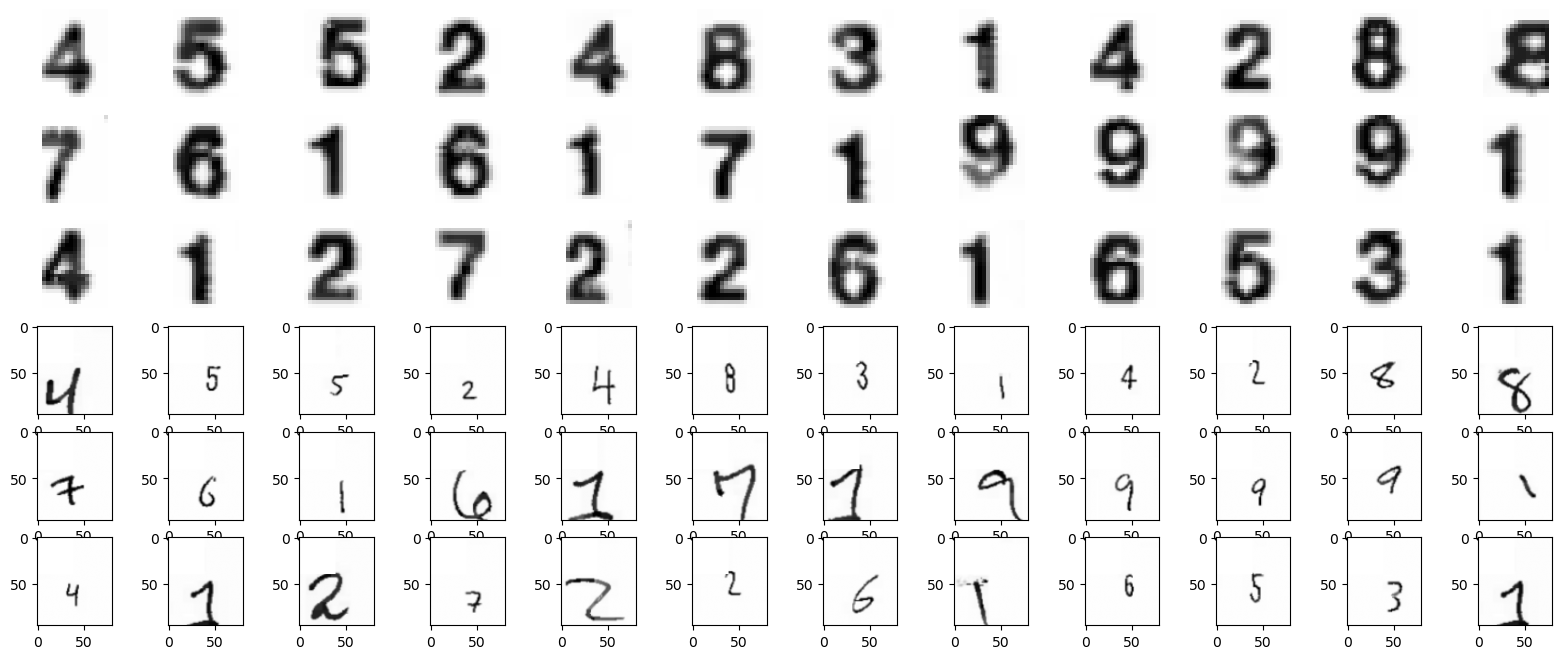

Subimage: 1152
Label List: 1152
Typed List: 1152
Drawing List: 1152


In [54]:
# For each subimage in the typeLabeled data, split into two new images.  
# The first will be the top left box, and the second will be the original image with the top left box removed.
def split_images(subImages):
    labelList = []
    typedList = []
    drawingList = []

    for i in range(len(subImages)):
        for j in range(0, 1):
            for k in range(0, 1):       
                labImage = subImages[i][9+j:32+j, 11+k:28+k]
                typedList.append(labImage)
        
                img = subImages[i].copy()
                img[0:45, 0:45] = 255
                # crop the image to remove the first two rows and columns
                img = img[5+j:100+j, 6+k:86+k]
                drawingList.append(img)

                labelList.append(labels[i])
    return typedList, drawingList, labelList

typedListTrain, drawingListTrain, labelListTrain = split_images(subImagesAdjust)
typedListTest, drawingListTest, labelListTest = split_images(subImagesTestAdjust)

# Display random images in the label list in a grid.
m=3
n=12
fig, axs = plt.subplots(m*2, n, figsize=(20, 8))
for i in range(m):
    for j in range(n):
        ri = random.randint(0, len(drawingListTrain)-1)
        axs[i, j].imshow(typedListTrain[ri], cmap='gray')
        axs[i, j].axis('off')
        axs[i+m, j].imshow(drawingListTrain[ri], cmap='gray')
        axs[i+m, j].axis('on')
plt.show()

# Display shape of data
print(f'Subimage: {len(subImages)}')
print(f'Label List: {len(labelListTrain)}')
print(f'Typed List: {len(typedListTrain)}')
print(f'Drawing List: {len(drawingListTrain)}')


In [55]:
# Let's save all of the previous images to a folder. We don't need them
# for this notebook, but we will reuse them later.
!mkdir -p handDigits/images
i = 0
for image in drawingListTrain:
    plt.imsave(f'handDigits/images/im_{i}.png', image, cmap='gray')
    i += 1

## Reducing Data Size for Faster Processing and to Reduce Overfitting

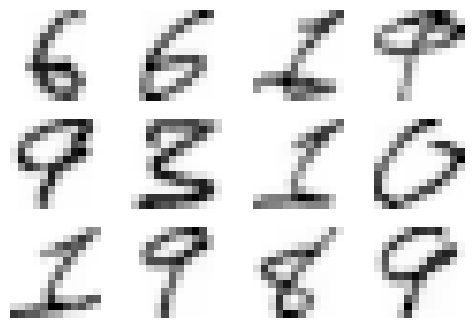

In [56]:
# The drawings are pretty big.  Let's crop away the white space and then resize them to 12x12 pixels.
from skimage.transform import resize

def findGroup(vec):
    # find the sub-vector that contains the largest number of sequential non-zero elements
    min = 0
    max = 0
    count = 1
    maxCount = 1
    for i in range(1,len(vec)):
        if vec[i] > 0 or vec[i-1] > 0:
            count += 1
            if count > maxCount:
                max = i
                min = i - count + 1
                maxCount = count
        else:
            count = 0
    return min, max

def cropAndResize(imgs, size=(12, 12)):
    imgsOut = []
    for i in range(len(imgs)):
        # Find the average of the first lines of all images.
        imgCopy = imgs[i].copy()
        # try:
        # find which rows and columns are not white
        rows = np.min(imgCopy,axis=1) < 200
        min0, max0 = findGroup(rows)

        cols = np.min(imgCopy, axis=0) < 200
        min1, max1 = findGroup(cols)
        imgCopy = imgCopy[min0:max0, min1:max1]

        # pad image on left and right to make square
        pad = (imgCopy.shape[0] - imgCopy.shape[1]) // 3
        if pad > 0:
            imgCopy = np.pad(imgCopy, ((0, 0), (pad, pad)), mode='constant', constant_values=255)

        imgsOut.append(resize(imgCopy, size, anti_aliasing=True))
        # except:
        #     imgsOut.append(np.zeros(size))
        #     print(f'Error resizing image {i} - set to zero')
    return imgsOut

typedListResizedTrain = cropAndResize(typedListTrain)
typedListResizedTest = cropAndResize(typedListTest)
drawingListResizedTrain = cropAndResize(drawingListTrain)
drawingListResizedTest = cropAndResize(drawingListTest)

# Display the last 12 images in the drawing list in a 3x4 grid.
fig, axs = plt.subplots(3, 4, figsize=(6, 4))
for i in range(3):
    for j in range(4):
        axs[i, j].imshow(drawingListResizedTrain[-(i * 4 + j)], cmap='gray')
        axs[i, j].axis('off')
plt.show()

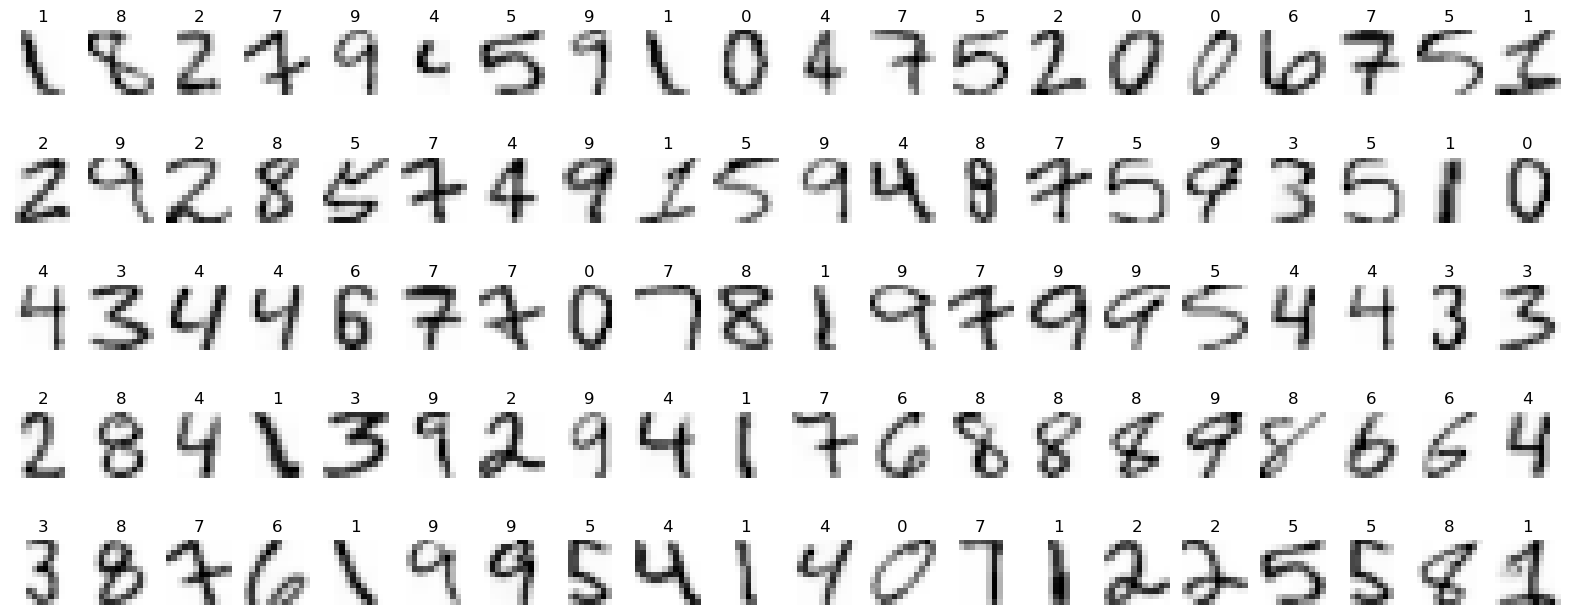

In [58]:
# Perform the classification on either the typed or the handwritten images.
digitListTrain = drawingListResizedTrain
digitListTest = drawingListResizedTest

# Loop through the label list and create a matrix where each row is the flattened version of the corresponding image in the label list.
dataMatrixTrain = np.zeros((len(digitListTrain),len(digitListTrain[0].flatten())))
for i in range(len(digitListTrain)):
    dataMatrixTrain[i] = digitListTrain[i].flatten()

dataMatrixTest = np.zeros((len(digitListTest),len(digitListTest[0].flatten())))
for i in range(len(digitListTest)):
    dataMatrixTest[i] = digitListTest[i].flatten()

# Display the first 36 images in the label list in a 3x12 grid, with the corresponding label as the title.
fig, axs = plt.subplots(5, 20, figsize=(20, 8))
for i in range(5):
    for j in range(20):
        ri = random.randint(0, len(digitListTrain)-1)
        axs[i, j].imshow(digitListTrain[ri], cmap='gray')
        axs[i, j].set_title(labelListTrain[ri])
        axs[i, j].axis('off')


# Building and Running Classifiers

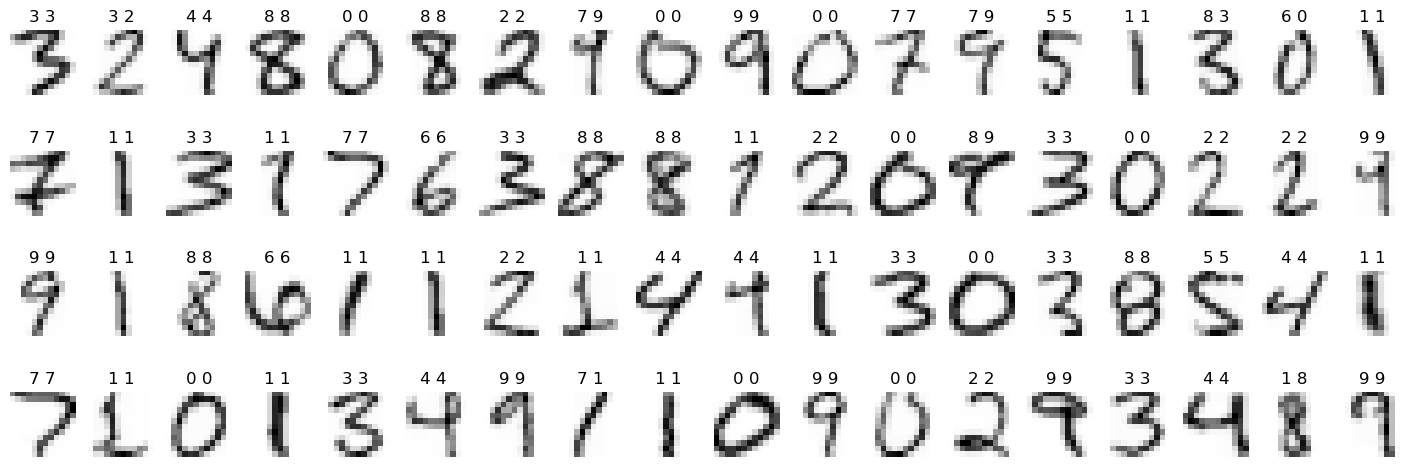

Training Accuracy: 0.9722222222222222
Testing Accuracy: 0.8055555555555556


In [59]:
# Associate the labelMatrix with the labels list, and build a classifier using the first 200 images in the label list.
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
nTrain = dataMatrixTrain.shape[0]
nTest = dataMatrixTest.shape[0]
classifier.fit(dataMatrixTrain[:nTrain], labelListTrain[:nTrain])

# Use the classifier to predict the labels of the training and test data.
predictedLabelsTrain = classifier.predict(dataMatrixTrain)
predictedLabelsTest = classifier.predict(dataMatrixTest)

# Display the last 24 images in the drawing testing list in a 4x12 grid, with the predicted labels as titles.
fig, axs = plt.subplots(4, 18, figsize=(18, 6))
for i in range(4):
    for j in range(18):
        r1 = random.randint(0, nTest-1)
        axs[i, j].imshow(digitListTest[r1], cmap='gray')
        axs[i, j].set_title(f'{predictedLabelsTest[r1]} {labelListTest[r1]}')
        axs[i, j].axis('off')
plt.show()

print('Training Accuracy:', np.mean(predictedLabelsTrain[:nTrain] == labelListTrain[:nTrain]))
print('Testing Accuracy:', np.mean(predictedLabelsTest == labelListTest))

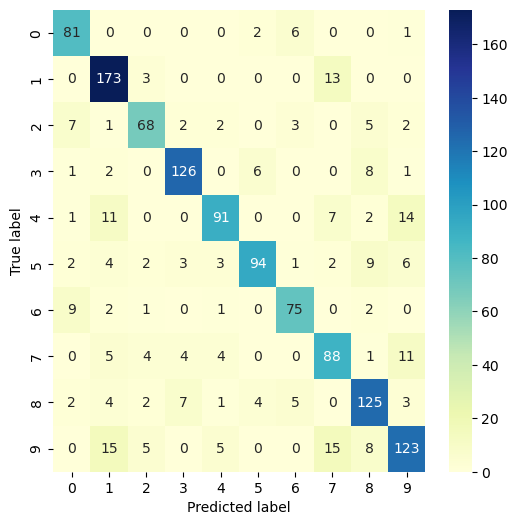

In [60]:
# Create a confusion matrix for the classifier on the predicted labels.
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(labelListTest, predictedLabelsTest)

# Display the confusion matrix as a heatmap.
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.heatmap(confusionMatrix, annot=True, cmap='YlGnBu', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Testing Accuracy: 0.8618827160493827


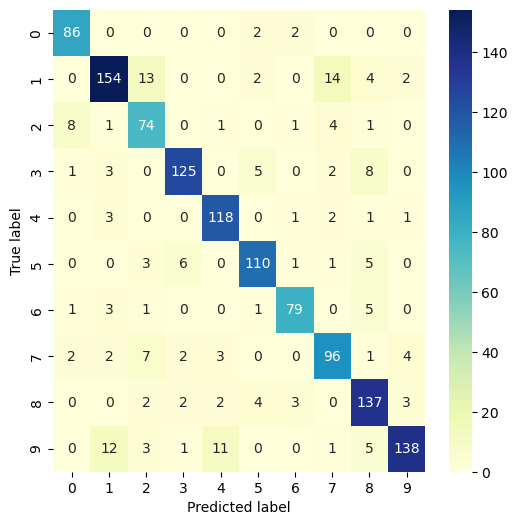

In [61]:
# Let's try to improve the accuracy by using a different classifier.
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(dataMatrixTrain, labelListTrain)
predictedLabelsTest = classifier.predict(dataMatrixTest)
confusionMatrix = confusion_matrix(labelListTest, predictedLabelsTest)
print('Testing Accuracy:', np.mean(predictedLabelsTest == labelListTest))

plt.figure(figsize=(6, 6))
sns.heatmap(confusionMatrix, annot=True, cmap='YlGnBu', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Testing Accuracy: 0.8935185185185185


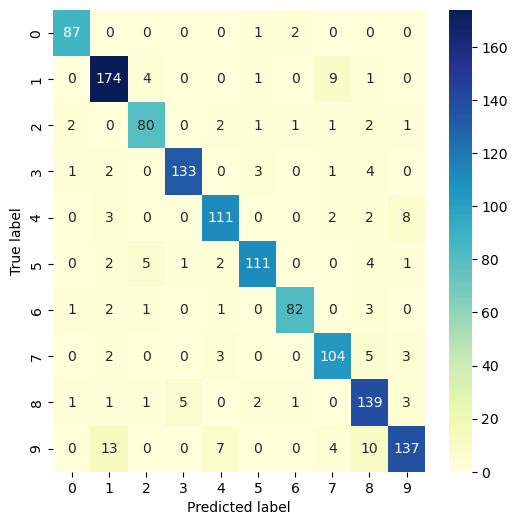

In [62]:
# Let's try with a support vector machine.
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(dataMatrixTrain, labelListTrain)
predictedLabelsTrain = classifier.predict(dataMatrixTrain)
predictedLabelsTest = classifier.predict(dataMatrixTest)

confusionMatrix = confusion_matrix(labelListTest, predictedLabelsTest)
print('Testing Accuracy:', np.mean(predictedLabelsTest == labelListTest))

plt.figure(figsize=(6, 6))
sns.heatmap(confusionMatrix, annot=True, cmap='YlGnBu', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

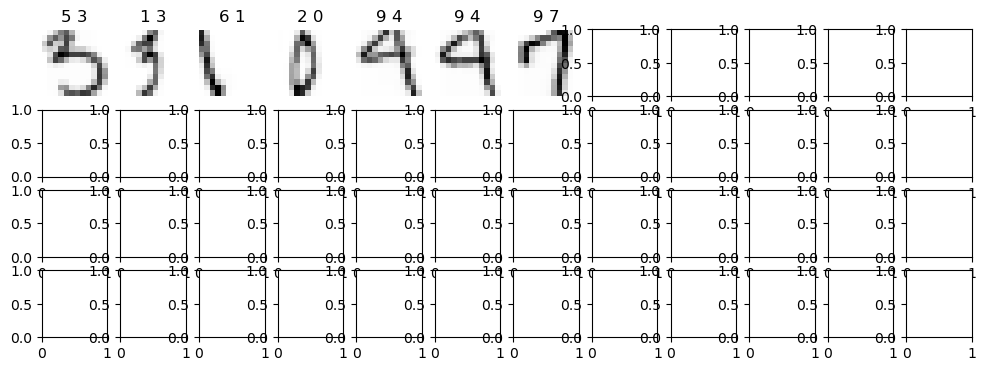

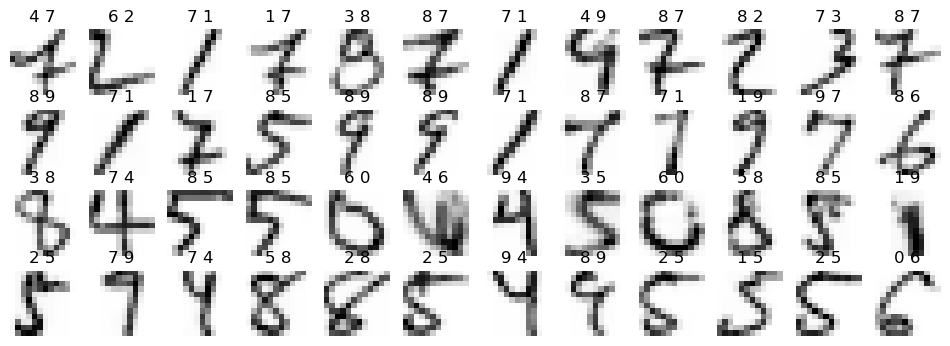

In [63]:
# Show training images that were misclassified.
indicesWrong = np.where(predictedLabelsTrain != labelListTrain)[0]
fig, axs = plt.subplots(4, 12, figsize=(12, 4))
for i in range(4):
    for j in range(12):
        if i * 12 + j >= len(indicesWrong):
            continue
        r1 = indicesWrong[i * 12 + j]
        
        axs[i, j].imshow(digitListTrain[r1], cmap='gray')
        axs[i, j].set_title(f'{predictedLabelsTrain[r1]} {labelListTrain[r1]}')
        axs[i, j].axis('off')

# Show test images that were misclassified.
indicesWrong = np.where(predictedLabelsTest != labelListTest)[0]
fig, axs = plt.subplots(4, 12, figsize=(12, 4))
for i in range(4):
    for j in range(12):
        if i * 12 + j >= len(indicesWrong):
            continue
        r1 = indicesWrong[i * 12 + j]
        
        axs[i, j].imshow(digitListTest[r1], cmap='gray')
        axs[i, j].set_title(f'{predictedLabelsTest[r1]} {labelListTest[r1]}')
        axs[i, j].axis('off')